# Basics
* Triton program model
* Triton perf report

In [ ]:
import torch
import triton
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()

@triton.jit
def add_kernel(
    x_ptr,
    y_ptr,
    out_ptr,
    n,
    BLOCK_SIZE: tl.constexpr
):
    pid = tl.program_id(axis=0)
    offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    out = x + y
    tl.store(out_ptr + offsets, out, mask=mask)
    
def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n = output.numel()
    grid = lambda meta: (triton.cdiv(n, meta["BLOCK_SIZE"]),)
    add_kernel[grid](x, y, output, n, BLOCK_SIZE=1024)
    return output

def sanity_check():
    SIZE = 98432
    x = torch.rand(SIZE, device=DEVICE)
    y = torch.rand(SIZE, device=DEVICE)
    output_torch = x + y
    output_triton = add(x, y)
    print("All close:", torch.allclose(output_torch, output_triton))
    print(f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}")

In [ ]:
sanity_check()

All close: True
The maximum difference between torch and triton is 0.0


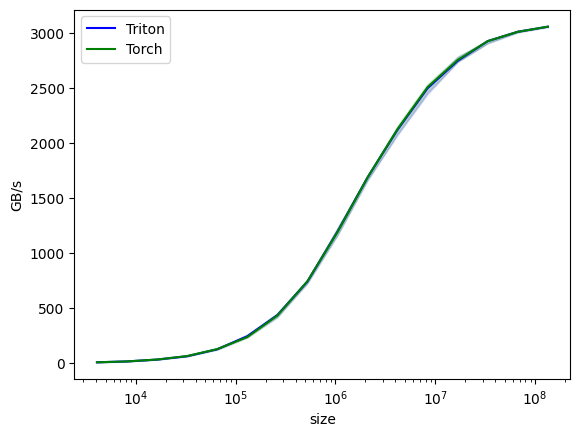

vector-add-performance:
           size       Triton        Torch
0        4096.0     8.302703     8.170213
1        8192.0    16.253968    16.253968
2       16384.0    33.032257    33.391304
3       32768.0    63.340208    65.015874
4       65536.0   126.680417   127.999995
5      131072.0   245.760006   237.449270
6      262144.0   436.906674   433.057275
7      524288.0   741.916954   744.727267
8     1048576.0  1195.185402  1191.563601
9     2097152.0  1687.622326  1687.622326
10    4194304.0  2122.623493  2128.368120
11    8388608.0  2500.578631  2510.557073
12   16777216.0  2748.560983  2756.388270
13   33554432.0  2928.301680  2928.301680
14   67108864.0  3013.149329  3012.428125
15  134217728.0  3059.302783  3059.860533


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="vector-add-performance",
        args={}
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles) # type:ignore
    elif provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles) # type:ignore
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
    
benchmark.run(print_data=True, show_plots=True)